In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from pathlib import Path
from PIL import Image
from collections import defaultdict
from torchvision.models import resnet18, ResNet18_Weights
from umap.umap_ import UMAP
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
from tqdm import tqdm
import time
from torchvision.transforms import v2

In [2]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)
        
        # Store tumor type in self.labels (0 = non-recurrent, 1 = recurrent)
        for img in self.image_files:
            if "positive" in img:
                self.labels.append(1)
            else:
                self.labels.append(0)
               
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        label = self.labels[idx]  # Get the corresponding label
        
        if self.transform:
            image = self.transform(image)
            
        return image, label  # Return both image and label


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize to 224x224 (if not already)
    transforms.ToTensor(), # convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/einstein_patches/'
dataset = SingleChannelDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

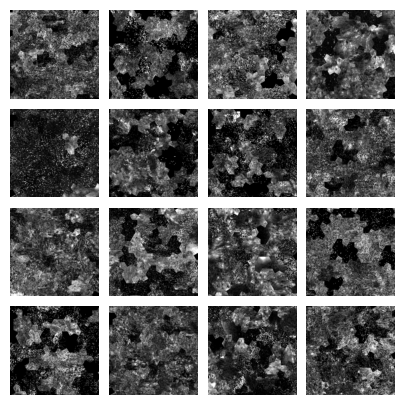

In [4]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [5]:
from transformers import ConvNextForImageClassification

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

num_classes = 2 # number of classes in the output

# split dataset into training and testing sets
train_size = int(0.7 * len(dataset))  # 70% for training
test_size = len(dataset) - train_size  # Remaining 30% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Epoch 1/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 2.4894, Train Accuracy: 0.4253


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.7268, Test Accuracy: 0.5486
Epoch 2/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.5070, Train Accuracy: 0.7739


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.4740, Test Accuracy: 0.7712
Epoch 3/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.2341, Train Accuracy: 0.9233


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.2670, Test Accuracy: 0.8903
Epoch 4/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.0883, Train Accuracy: 0.9798


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.1837, Test Accuracy: 0.9310
Epoch 5/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.0361, Train Accuracy: 1.0000


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.1653, Test Accuracy: 0.9436


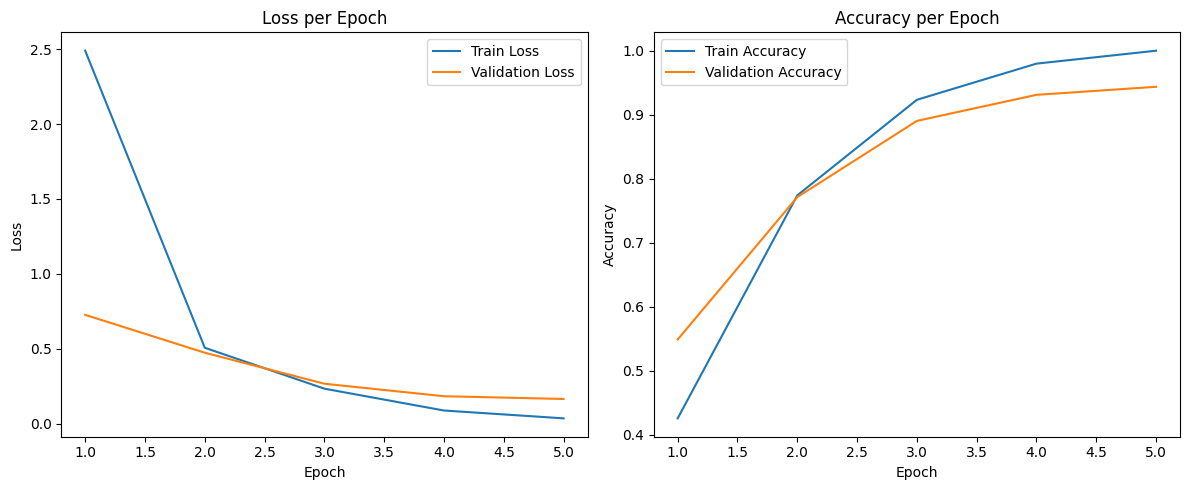

In [6]:
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

def train(model, train_loader, criterion, optimizer, device):
    model = model.to(device)
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs).logits  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    model = model.to(device)
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

num_epochs = 5
device = "cuda"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate (if scheduler is used)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting training and validation loss and accuracy
epochs = range(1, num_epochs + 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax[0].plot(epochs, train_losses, label='Train Loss')
ax[0].plot(epochs, val_losses, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss per Epoch')
ax[0].legend()

# Accuracy plot
ax[1].plot(epochs, train_accuracies, label='Train Accuracy')
ax[1].plot(epochs, val_accuracies, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy per Epoch')
ax[1].legend()

plt.tight_layout()
plt.show()

In [7]:
class MultiChannelDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.patch_dict = defaultdict(list)
        self.labels = []
        self.samples = []
        
        # populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            if not os.path.isdir(full_path):
                continue
                
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            full_image_path.sort()
           
            for img_path in full_image_path:
                img_array = self._load_image_as_tensor(img_path)
                # use the index of the patch along with its category (positive/negative) as key for the dictionary
                sample_key = os.path.basename(img_path)[-5]
                if "positive" in img_path:
                    sample_key = "positive" + "_" + sample_key
                else:
                    sample_key = "negative" + "_" + sample_key
                self.patch_dict[sample_key].append(img_array)
                
        # convert the dictionary into list so we can get the samples by indexing
        for patch in self.patch_dict:
            self.samples.append([]) # create a new list for each "sample"
            self.samples[-1].extend(self.patch_dict[patch]) # add the patch to the list
            if "positive" in patch:
                self.labels.append(1)
            else:
                self.labels.append(0)
       
    def _load_image_as_tensor(self, path):
        """
        Load an image as a tensor.
       
        Args:
            path (str): Path to image file
           
        Returns:
            torch.Tensor: Image as tensor with shape [1, H, W]
        """
        # open image using PIL
        with Image.open(path) as img:
            # convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            # convert to NumPy array
            img_np = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
            img_tensor = torch.from_numpy(img_np).unsqueeze(0)
            # transform the tensor if needed
            if self.transform:
                img_tensor = self.transform(img_tensor)
        return img_tensor
    
    def __len__(self):
        return len(self.samples)
       
    def __getitem__(self, idx):
        patch = self.samples[idx]
        label = self.labels[idx]
       
        # stack list of images for each tissue to form a multi-channel tensor
        sample_tensor = torch.stack(patch, dim=0)  # Shape: [num_channels, 1, H, W]
        sample_tensor = sample_tensor.squeeze(1)  # Remove the color channel, shape: [num_channels, H, W]
        
        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)
           
        return sample_tensor, label

In [8]:
class MultiChannelResnet(nn.Module):
    def __init__(self, num_channels=50, num_classes=2):
        """
        Modified ResNet model to handle multi-channel inputs beyond RGB.
        
        Args:
            num_channels (int): Number of input channels (default: 50)
            num_classes (int): Number of output classes (default: 2)
        """
        super(MultiChannelResnet, self).__init__()
        
        # Load a pretrained ResNet model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Replace the first convolutional layer to accept num_channels instead of 3
        original_layer = self.model.conv1
        new_layer = nn.Conv2d(
            num_channels, 
            original_layer.out_channels,
            kernel_size=original_layer.kernel_size,
            stride=original_layer.stride,
            padding=original_layer.padding,
            bias=(original_layer.bias is not None)
        )
        
        # Initialize the new layer with scaled weights from pretrained model
        with torch.no_grad():
            # Scale the weights to maintain activation magnitude
            scale_factor = 3 / num_channels  # 3 is original RGB channels
            # Only use the first 3 channels for initialization if using pretrained weights
            if num_channels > 3:
                new_layer.weight[:, :3, :, :] = original_layer.weight * scale_factor
                # Initialize remaining channels with small random values
                nn.init.kaiming_normal_(new_layer.weight[:, 3:, :, :], mode='fan_out')
            else:
                new_layer.weight = torch.nn.Parameter(original_layer.weight[:, :num_channels, :, :] * scale_factor)
        
        # Replace the layer
        self.model.conv1 = new_layer
        
        # Modify the final fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_channels, height, width]
        
        Returns:
            torch.Tensor: Output predictions of shape [batch_size, num_classes]
        """
        return self.model(x)

In [9]:
def train_model_with_visualization(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    
    # lists to store metrics for visualization
    train_losses = []
    val_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        # training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        # Store training metrics
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        # calculate testing metrics
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = correct / total
        
        # store validation metrics
        val_losses.append(test_loss)
        test_accs.append(test_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {test_loss:.4f}, Val Acc: {test_accuracy:.4f}')
    print(train_accs)
    print(test_accs)
    
    return train_losses, val_losses, train_accs, test_accs

def plot_metrics(train_losses, val_losses, train_accs, val_accs, epochs):
    """
    Plot training and validation metrics.
    
    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        train_accs: List of training accuracies per epoch
        test_accs: List of validation accuracies per epoch
        epochs: Number of training epochs
    """
    epochs_range = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, epochs + 1, step=max(1, epochs // 10)))
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()


Epoch 1/20, Train Loss: 1.9644, Train Acc: 0.6667, Val Loss: 5.5865, Val Acc: 0.5000
Epoch 2/20, Train Loss: 1.4477, Train Acc: 0.8333, Val Loss: 0.5991, Val Acc: 0.6667
Epoch 3/20, Train Loss: 0.7958, Train Acc: 0.9167, Val Loss: 6.6286, Val Acc: 0.5000
Epoch 4/20, Train Loss: 0.4529, Train Acc: 0.9167, Val Loss: 8.7885, Val Acc: 0.5000
Epoch 5/20, Train Loss: 1.4288, Train Acc: 0.9167, Val Loss: 4.2512, Val Acc: 0.5000
Epoch 6/20, Train Loss: 0.9807, Train Acc: 0.8333, Val Loss: 4.9661, Val Acc: 0.5000
Epoch 7/20, Train Loss: 0.0254, Train Acc: 1.0000, Val Loss: 10.2842, Val Acc: 0.5000
Epoch 8/20, Train Loss: 0.2363, Train Acc: 0.9167, Val Loss: 5.4567, Val Acc: 0.6667
Epoch 9/20, Train Loss: 0.0191, Train Acc: 1.0000, Val Loss: 2.6195, Val Acc: 0.8333
Epoch 10/20, Train Loss: 0.0568, Train Acc: 1.0000, Val Loss: 1.1633, Val Acc: 0.8333
Epoch 11/20, Train Loss: 2.6862, Train Acc: 0.7500, Val Loss: 0.2933, Val Acc: 0.8333
Epoch 12/20, Train Loss: 0.0253, Train Acc: 1.0000, Val Loss: 

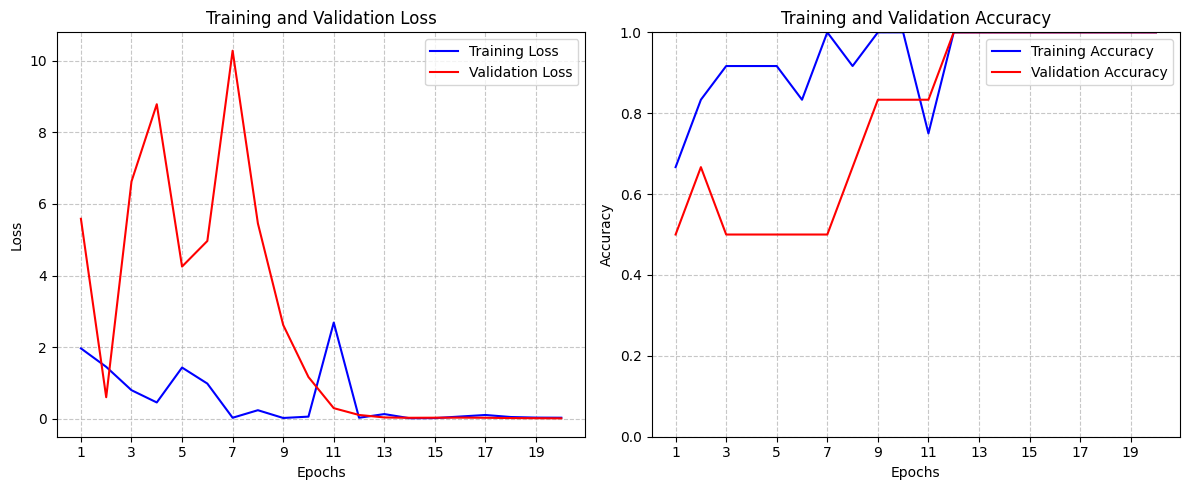

In [10]:
multi_channel_dataset = MultiChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches/', transform=None)


# calculate split lengths
total_len = len(multi_channel_dataset)
train_len = int(0.7 * total_len)
test_len = total_len - train_len

mc_train_dataset, mc_test_dataset = random_split(multi_channel_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

# create data loaders
mc_train_loader = DataLoader(
    mc_train_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4
)

mc_test_loader = DataLoader(
    mc_test_dataset, 
    batch_size=4, 
    shuffle=False, 
    num_workers=4
)

 # set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
model = MultiChannelResnet(num_channels=59, num_classes=2).to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
"""optimizer = torch.optim.SGD(model.parameters(), 
                           lr=0.005, 
                           momentum=0.5, 
                           weight_decay=1e-5)"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# train with visualization
train_losses, test_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, mc_train_loader, mc_test_loader, epochs=20)

plot_metrics(train_losses, test_losses, train_accs, val_accs, epochs=20)

Epoch 1/20, Train Loss: 12.0717, Train Acc: 0.8223, Val Loss: 212.5920, Val Acc: 0.6583
Epoch 2/20, Train Loss: 3.8319, Train Acc: 0.9367, Val Loss: 86.9999, Val Acc: 0.7398
Epoch 3/20, Train Loss: 1.9615, Train Acc: 0.9731, Val Loss: 8.7386, Val Acc: 0.9530
Epoch 4/20, Train Loss: 0.7733, Train Acc: 0.9906, Val Loss: 20.2030, Val Acc: 0.9248
Epoch 5/20, Train Loss: 1.9159, Train Acc: 0.9623, Val Loss: 18.6286, Val Acc: 0.9091
Epoch 6/20, Train Loss: 0.3243, Train Acc: 0.9987, Val Loss: 21.4531, Val Acc: 0.9279
Epoch 7/20, Train Loss: 0.0961, Train Acc: 1.0000, Val Loss: 9.5201, Val Acc: 0.9561
Epoch 8/20, Train Loss: 0.0334, Train Acc: 1.0000, Val Loss: 3.0176, Val Acc: 0.9843
Epoch 9/20, Train Loss: 0.0296, Train Acc: 1.0000, Val Loss: 3.3728, Val Acc: 0.9812
Epoch 10/20, Train Loss: 0.0108, Train Acc: 1.0000, Val Loss: 3.6115, Val Acc: 0.9843
Epoch 11/20, Train Loss: 0.0152, Train Acc: 1.0000, Val Loss: 3.5803, Val Acc: 0.9843
Epoch 12/20, Train Loss: 0.0125, Train Acc: 1.0000, Val 

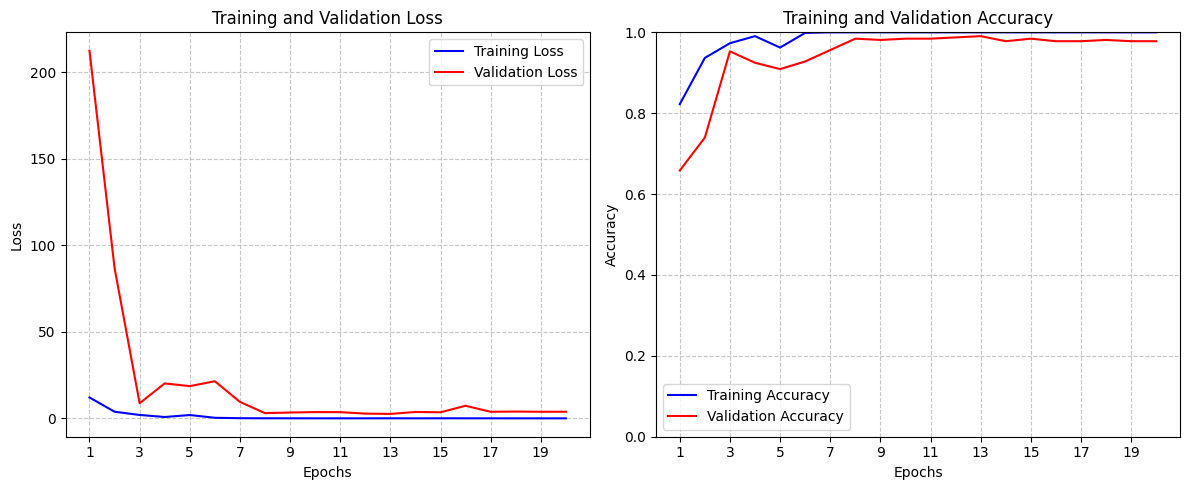

In [11]:

# train the model with SingleChannel Dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = SingleChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches/', transform=transform)


# calculate split lengths
total_len = len(dataset)
train_len = int(0.7 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

# create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=4, 
    shuffle=False, 
    num_workers=4
)

# create model
model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
"""optimizer = torch.optim.SGD(model.parameters(), 
                           lr=0.005, 
                           momentum=0.5, 
                           weight_decay=1e-5)"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# train with visualization
train_losses, test_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, train_loader, test_loader, epochs=20)

plot_metrics(train_losses, test_losses, train_accs, val_accs, epochs=20)

### Run the models again with a new set of reshuffled Einstein patches

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize to 224x224 (if not already)
    transforms.Lambda(lambda img: img.convert("RGB")),  # transform to RGB image
    transforms.ToTensor(), # convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/einstein_patches_2/'
dataset = SingleChannelDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

num_classes = 2 # number of classes in the output

# split dataset into training and testing sets
train_size = int(0.7 * len(dataset))  # 70% for training
test_size = len(dataset) - train_size  # Remaining 30% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

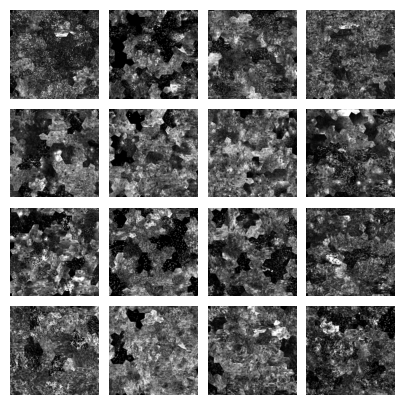

In [13]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

Epoch 1/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 2.4613, Train Accuracy: 0.4011


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.6978, Test Accuracy: 0.6332
Epoch 2/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.4833, Train Accuracy: 0.7604


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.4917, Test Accuracy: 0.7774
Epoch 3/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.2933, Train Accuracy: 0.8748


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.3704, Test Accuracy: 0.8213
Epoch 4/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.1404, Train Accuracy: 0.9529


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.2517, Test Accuracy: 0.8966
Epoch 5/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.0675, Train Accuracy: 0.9825


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.2159, Test Accuracy: 0.9185


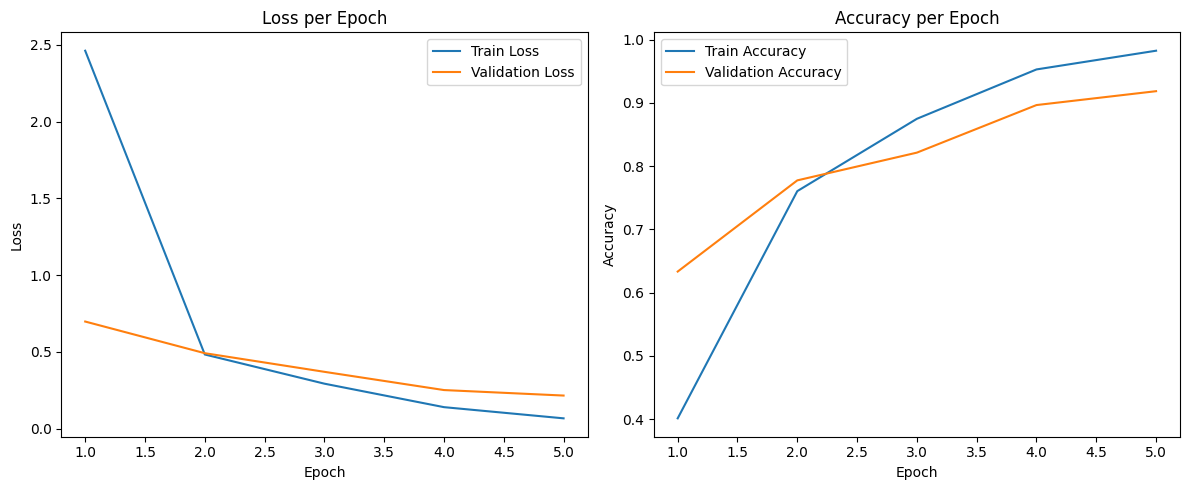

In [14]:
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

num_epochs = 5
device = "cuda"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate (if scheduler is used)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting training and validation loss and accuracy
epochs = range(1, num_epochs + 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax[0].plot(epochs, train_losses, label='Train Loss')
ax[0].plot(epochs, val_losses, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss per Epoch')
ax[0].legend()

# Accuracy plot
ax[1].plot(epochs, train_accuracies, label='Train Accuracy')
ax[1].plot(epochs, val_accuracies, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy per Epoch')
ax[1].legend()

plt.tight_layout()
plt.show()

Epoch 1/20, Train Loss: 0.8723, Train Acc: 1.0000, Val Loss: 9.6230, Val Acc: 0.5000
Epoch 2/20, Train Loss: 0.0642, Train Acc: 1.0000, Val Loss: 2.2585, Val Acc: 0.0000
Epoch 3/20, Train Loss: 4.3602, Train Acc: 0.8333, Val Loss: 6.1462, Val Acc: 0.5000
Epoch 4/20, Train Loss: 4.6712, Train Acc: 0.7500, Val Loss: 11.8895, Val Acc: 0.5000
Epoch 5/20, Train Loss: 1.4487, Train Acc: 0.9167, Val Loss: 23.3157, Val Acc: 0.5000
Epoch 6/20, Train Loss: 0.2717, Train Acc: 0.9167, Val Loss: 17.0701, Val Acc: 0.5000
Epoch 7/20, Train Loss: 0.1262, Train Acc: 1.0000, Val Loss: 13.4448, Val Acc: 0.5000
Epoch 8/20, Train Loss: 0.0197, Train Acc: 1.0000, Val Loss: 8.1624, Val Acc: 0.5000
Epoch 9/20, Train Loss: 0.0759, Train Acc: 1.0000, Val Loss: 2.8099, Val Acc: 0.5000
Epoch 10/20, Train Loss: 1.9979, Train Acc: 0.7500, Val Loss: 1.1968, Val Acc: 0.6667
Epoch 11/20, Train Loss: 0.3963, Train Acc: 0.9167, Val Loss: 0.0016, Val Acc: 1.0000
Epoch 12/20, Train Loss: 0.3561, Train Acc: 0.9167, Val Los

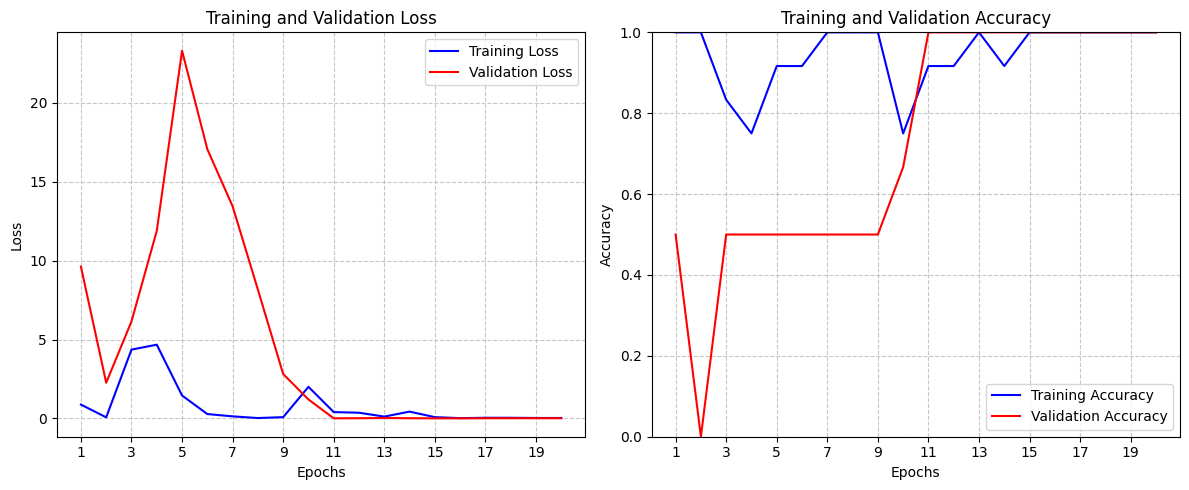

In [15]:
multi_channel_dataset = MultiChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches_2/', transform=None)


# calculate split lengths
total_len = len(multi_channel_dataset)
train_len = int(0.7 * total_len)
test_len = total_len - train_len

mc_train_dataset, mc_test_dataset = random_split(multi_channel_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

# create data loaders
mc_train_loader = DataLoader(
    mc_train_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4
)

mc_test_loader = DataLoader(
    mc_test_dataset, 
    batch_size=4, 
    shuffle=False, 
    num_workers=4
)

 # set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
model = MultiChannelResnet(num_channels=59, num_classes=2).to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# train with visualization
train_losses, test_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, mc_train_loader, mc_test_loader, epochs=20)

plot_metrics(train_losses, test_losses, train_accs, val_accs, epochs=20)

Epoch 1/20, Train Loss: 10.4799, Train Acc: 0.8129, Val Loss: 246.0098, Val Acc: 0.6144
Epoch 2/20, Train Loss: 3.7416, Train Acc: 0.9394, Val Loss: 93.5927, Val Acc: 0.6583
Epoch 3/20, Train Loss: 3.2463, Train Acc: 0.9542, Val Loss: 12.8944, Val Acc: 0.9373
Epoch 4/20, Train Loss: 1.1208, Train Acc: 0.9838, Val Loss: 43.0565, Val Acc: 0.8119
Epoch 5/20, Train Loss: 0.8582, Train Acc: 0.9906, Val Loss: 108.8356, Val Acc: 0.8025
Epoch 6/20, Train Loss: 2.8570, Train Acc: 0.9610, Val Loss: 24.3050, Val Acc: 0.8683
Epoch 7/20, Train Loss: 3.4781, Train Acc: 0.9354, Val Loss: 18.8465, Val Acc: 0.9248
Epoch 8/20, Train Loss: 1.7849, Train Acc: 0.9731, Val Loss: 86.7456, Val Acc: 0.7524
Epoch 9/20, Train Loss: 2.4802, Train Acc: 0.9798, Val Loss: 23.0131, Val Acc: 0.8746
Epoch 10/20, Train Loss: 2.9909, Train Acc: 0.9596, Val Loss: 95.4520, Val Acc: 0.8056
Epoch 11/20, Train Loss: 3.8143, Train Acc: 0.9367, Val Loss: 6.6549, Val Acc: 0.9655
Epoch 12/20, Train Loss: 0.9291, Train Acc: 0.9919

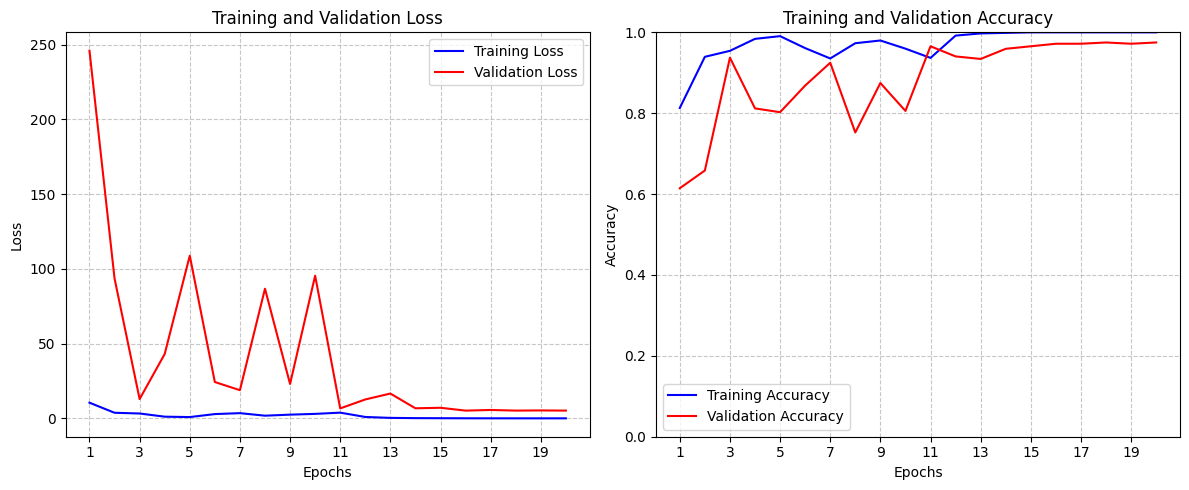

In [16]:

# train the model with SingleChannel Dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = SingleChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches_2/', transform=transform)


# calculate split lengths
total_len = len(dataset)
train_len = int(0.7 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

# create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=4, 
    shuffle=False, 
    num_workers=4
)

# create model
model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
"""optimizer = torch.optim.SGD(model.parameters(), 
                           lr=0.005, 
                           momentum=0.5, 
                           weight_decay=1e-5)"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# train with visualization
train_losses, test_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, train_loader, test_loader, epochs=20)

plot_metrics(train_losses, test_losses, train_accs, val_accs, epochs=20)

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize to 224x224 (if not already)
    transforms.Lambda(lambda img: img.convert("RGB")),  # transform to RGB image
    transforms.ToTensor(), # convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/einstein_patches_3/'
dataset = SingleChannelDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

num_classes = 2 # number of classes in the output

# split dataset into training and testing sets
train_size = int(0.7 * len(dataset))  # 70% for training
test_size = len(dataset) - train_size  # Remaining 30% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

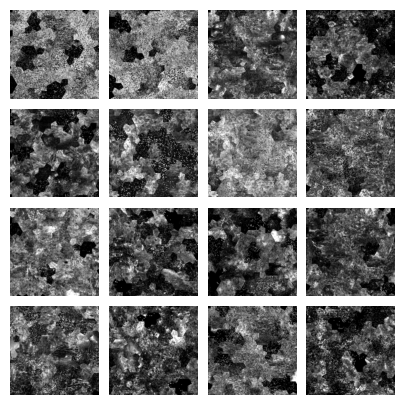

In [18]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

Epoch 1/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 2.4759, Train Accuracy: 0.4159


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.6262, Test Accuracy: 0.6834
Epoch 2/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.5626, Train Accuracy: 0.7281


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.5341, Test Accuracy: 0.7241
Epoch 3/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.3565, Train Accuracy: 0.8573


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.2865, Test Accuracy: 0.8871
Epoch 4/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.2014, Train Accuracy: 0.9314


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.2072, Test Accuracy: 0.9091
Epoch 5/5


  0%|          | 0/24 [00:00<?, ?it/s]

Train Loss: 0.1029, Train Accuracy: 0.9717


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.1517, Test Accuracy: 0.9310


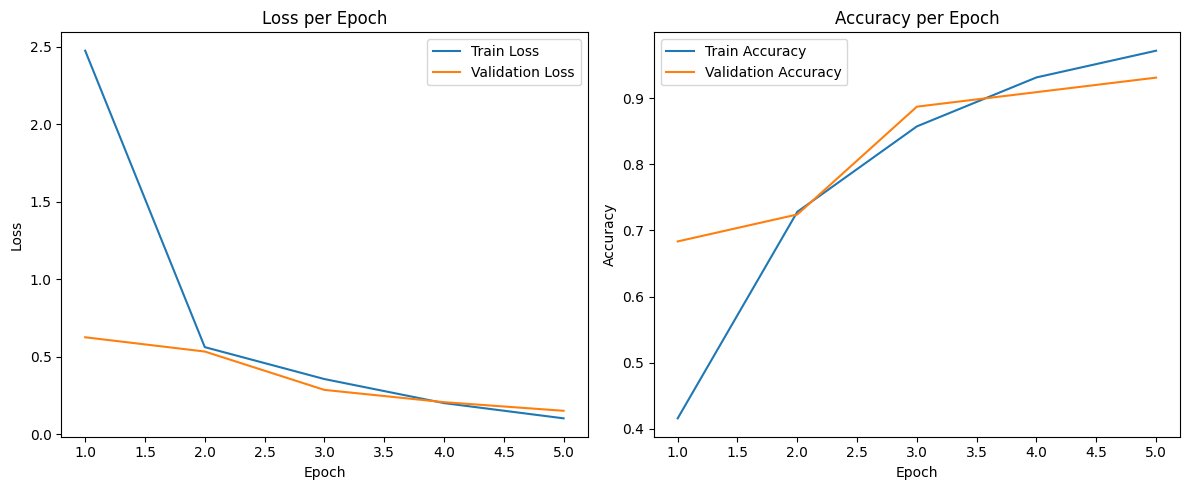

In [19]:
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

num_epochs = 5
device = "cuda"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate (if scheduler is used)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting training and validation loss and accuracy
epochs = range(1, num_epochs + 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax[0].plot(epochs, train_losses, label='Train Loss')
ax[0].plot(epochs, val_losses, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss per Epoch')
ax[0].legend()

# Accuracy plot
ax[1].plot(epochs, train_accuracies, label='Train Accuracy')
ax[1].plot(epochs, val_accuracies, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy per Epoch')
ax[1].legend()

plt.tight_layout()
plt.show()

Epoch 1/20, Train Loss: 1.5169, Train Acc: 0.7500, Val Loss: 0.7874, Val Acc: 0.8333
Epoch 2/20, Train Loss: 4.1015, Train Acc: 0.7500, Val Loss: 0.5171, Val Acc: 0.6667
Epoch 3/20, Train Loss: 1.5974, Train Acc: 0.8333, Val Loss: 5.0522, Val Acc: 0.5000
Epoch 4/20, Train Loss: 0.0313, Train Acc: 1.0000, Val Loss: 2.2037, Val Acc: 0.3333
Epoch 5/20, Train Loss: 0.8354, Train Acc: 0.8333, Val Loss: 3.2841, Val Acc: 0.5000
Epoch 6/20, Train Loss: 1.2236, Train Acc: 0.9167, Val Loss: 0.0064, Val Acc: 1.0000
Epoch 7/20, Train Loss: 0.1805, Train Acc: 1.0000, Val Loss: 0.0213, Val Acc: 1.0000
Epoch 8/20, Train Loss: 5.1229, Train Acc: 0.6667, Val Loss: 0.0704, Val Acc: 1.0000
Epoch 9/20, Train Loss: 0.0357, Train Acc: 1.0000, Val Loss: 0.5647, Val Acc: 0.8333
Epoch 10/20, Train Loss: 0.7914, Train Acc: 0.7500, Val Loss: 0.1610, Val Acc: 1.0000
Epoch 11/20, Train Loss: 0.3772, Train Acc: 0.9167, Val Loss: 0.0005, Val Acc: 1.0000
Epoch 12/20, Train Loss: 0.1139, Train Acc: 1.0000, Val Loss: 0

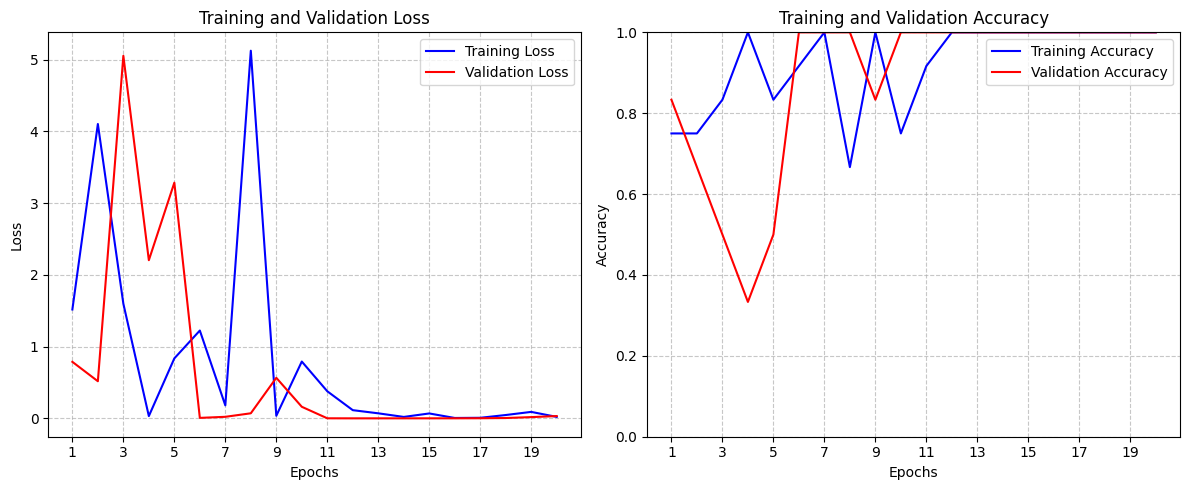

In [20]:
multi_channel_dataset = MultiChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches_3/', transform=None)


# calculate split lengths
total_len = len(multi_channel_dataset)
train_len = int(0.7 * total_len)
test_len = total_len - train_len

mc_train_dataset, mc_test_dataset = random_split(multi_channel_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

# create data loaders
mc_train_loader = DataLoader(
    mc_train_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4
)

mc_test_loader = DataLoader(
    mc_test_dataset, 
    batch_size=4, 
    shuffle=False, 
    num_workers=4
)


# create model
model = MultiChannelResnet(num_channels=59, num_classes=2).to(device)
model.to(device)
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# train with visualization
train_losses, test_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, mc_train_loader, mc_test_loader, epochs=20)

plot_metrics(train_losses, test_losses, train_accs, val_accs, epochs=20)

Epoch 1/20, Train Loss: 29.0990, Train Acc: 0.5734, Val Loss: 408.5989, Val Acc: 0.5643
Epoch 2/20, Train Loss: 15.9998, Train Acc: 0.6555, Val Loss: 136.3648, Val Acc: 0.4734
Epoch 3/20, Train Loss: 17.3692, Train Acc: 0.6285, Val Loss: 46.4617, Val Acc: 0.7241
Epoch 4/20, Train Loss: 14.5886, Train Acc: 0.6918, Val Loss: 47.6991, Val Acc: 0.7492
Epoch 5/20, Train Loss: 13.4855, Train Acc: 0.7133, Val Loss: 48.0630, Val Acc: 0.6708
Epoch 6/20, Train Loss: 12.0322, Train Acc: 0.7577, Val Loss: 38.6424, Val Acc: 0.7649
Epoch 7/20, Train Loss: 11.8809, Train Acc: 0.8075, Val Loss: 32.4380, Val Acc: 0.8150
Epoch 8/20, Train Loss: 11.7416, Train Acc: 0.7779, Val Loss: 29.5347, Val Acc: 0.8809
Epoch 9/20, Train Loss: 11.5961, Train Acc: 0.8358, Val Loss: 39.3811, Val Acc: 0.7304
Epoch 10/20, Train Loss: 10.8627, Train Acc: 0.8008, Val Loss: 142.7648, Val Acc: 0.7743
Epoch 11/20, Train Loss: 12.6672, Train Acc: 0.8008, Val Loss: 37.8106, Val Acc: 0.7586
Epoch 12/20, Train Loss: 10.4408, Trai

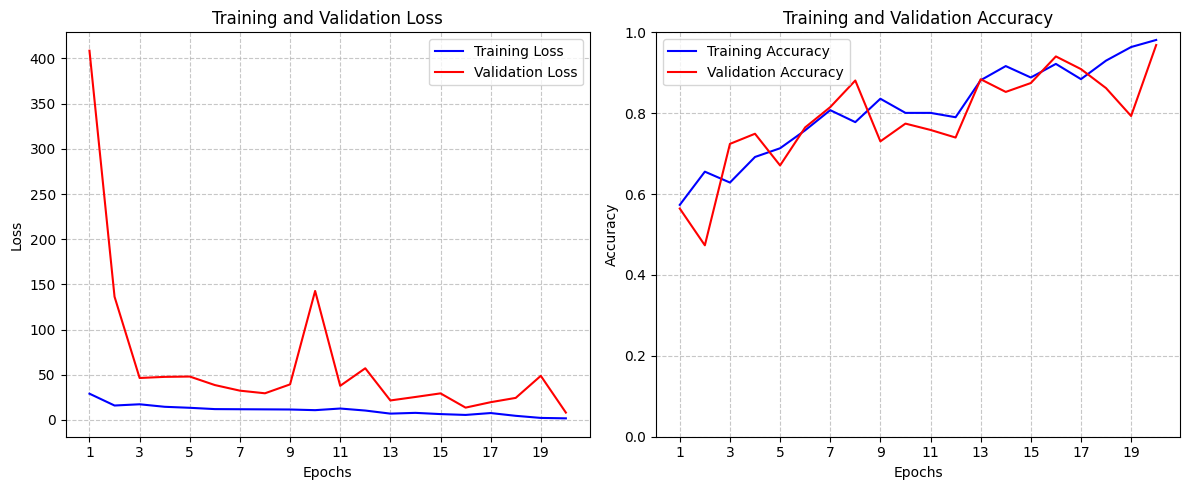

In [21]:

# train the model with SingleChannel Dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = SingleChannelDataset(folder_path='/home/mass_spec_img/mass_spec_img/data/einstein_patches_3/', transform=transform)


# calculate split lengths
total_len = len(dataset)
train_len = int(0.7 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

# create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=4, 
    shuffle=False, 
    num_workers=4
)

# create model
model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
"""optimizer = torch.optim.SGD(model.parameters(), 
                           lr=0.005, 
                           momentum=0.5, 
                           weight_decay=1e-5)"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

# train with visualization
train_losses, test_losses, train_accs, val_accs = train_model_with_visualization(model, criterion, optimizer, train_loader, test_loader, epochs=20)

plot_metrics(train_losses, test_losses, train_accs, val_accs, epochs=20)